## Spam Message Classifier

### Import necessary libraries 

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, learning_curve, cross_val_predict
from sklearn.model_selection import KFold
from sklearn import model_selection

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

# Model evaluation
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, average_precision_score


### Read and review the dataset 
The data was donwloaded from https://github.com/samimakhan/Spam-Classification-Project/tree/master/Naive-Bayes

In [3]:
# Read the csv file
df=pd.read_csv('spam.csv',encoding='ISO-8859-1')

print(df.columns)
df.head()

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# Remove unnecessary columns
cols_to_remove = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
df.drop(columns = cols_to_remove,inplace=True,axis=1)

In [5]:
df.describe()

,v1,v2
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
# Rename column names
df=df.rename(columns = {'v1':'Spam_Label', 'v2':'Text'})

In [8]:
# check missing data
df.isnull().sum()

Spam_Label    0
Text          0
dtype: int64

### Explonatory Data Analysis

In [9]:
# check target variable
target_col = 'Spam_Label'
df[target_col].value_counts()

ham     4825
spam     747
Name: Spam_Label, dtype: int64

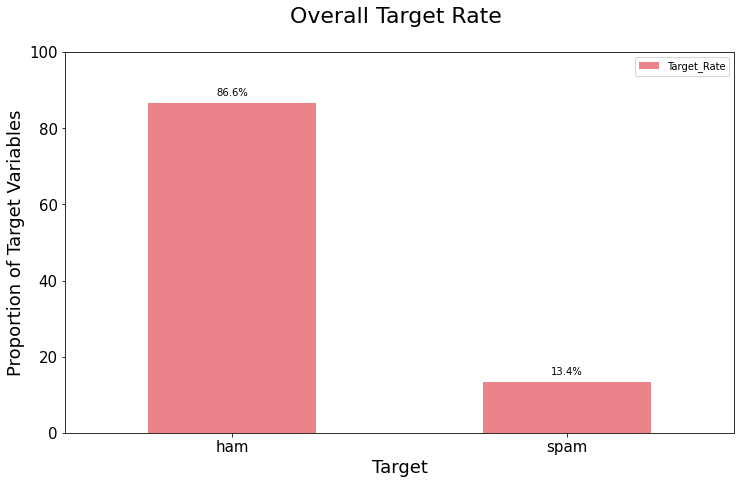

In [10]:
dfrate = pd.DataFrame(df[target_col].value_counts())
dfrate['Target_Rate'] = dfrate['Spam_Label']/(dfrate['Spam_Label'].sum()) * 100

# Plotting
ax =  dfrate[["Target_Rate"]].plot.bar(figsize =(12, 7), color = '#ec838a',fontsize = 15, ylim =(0,100))

plt.ylabel('Proportion of Target Variables',fontsize = "18")
plt.xlabel('Target',fontsize = "18")
plt.title('Overall Target Rate \n',fontsize = "22")

plt.legend(loc='upper right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")

# Adding label values
def add_value_labels(ax, spacing=5):   
    for rect in ax.patches:     
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2       
        space = spacing
        va = 'bottom'        
        if y_value < 0:           
            space *= -1          
            va = 'top'
        label = "{:.1f}%".format(y_value)    
        ax.annotate(label, (x_value, y_value),xytext=(0, space), textcoords="offset points", ha='center',va=va)
add_value_labels(ax)
ax.autoscale(enable=False, axis='both', tight=False)


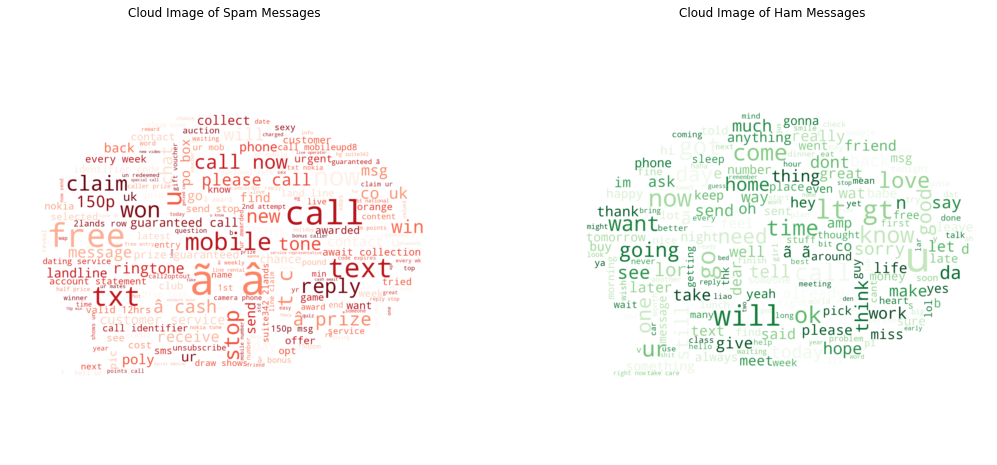

In [11]:
# Plot cloud of spam and ham emails

# Select spam and ham messages
dfspam = df[df['Spam_Label'] == 'spam']['Text']
dfham = df[df['Spam_Label'] == 'ham']['Text']
spamlistmerged = "".join(list(dfspam)).lower()
hamlistmerged = "".join(list(dfham)).lower()

comment_mask = np.array(Image.open("comment.png"))

# Create and generate a word cloud image:
wordcloud_spam = WordCloud(max_font_size = 200, margin=0, mask = comment_mask, background_color = "white", 
                      colormap="Reds").generate(spamlistmerged)
wordcloud_ham = WordCloud(max_font_size = 200, margin=0, mask = comment_mask, background_color = "white", 
                      colormap="Greens").generate(hamlistmerged) 
# Display the generated image
fig,ax =plt.subplots(nrows = 1,ncols = 2, figsize=[18,8])
plt.subplot(1,2,1)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title('Cloud Image of Spam Messages')
plt.axis("off")
plt.margins(x=0, y=0)
plt.subplot(1,2,2)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.title('Cloud Image of Ham Messages')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [12]:
# Encode target variable
X=df.Text
y=df.Spam_Label.apply(lambda x: 1 if x=='spam' else 0)

### Split dataset into training and test sets

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print('The shape of the X_train = ',X_train.shape)
print('The shape of the y_train = ',y_train.shape)
print('The shape of the X_test = ',X_test.shape)
print('The shape of the y_test= ',y_test.shape)

The shape of the X_train =  (3900,)
The shape of the y_train =  (3900,)
The shape of the X_test =  (1672,)
The shape of the y_test=  (1672,)


### Vectorize train and test set messages

In [14]:
# vectorize messages using TfidfVectorizer 
# converts collection of raw documents to a matrix of TF-IDF features.
# It's equivalent to CountVectorizer followed by TfidfTransformer.
X_train_list = X_train.tolist()
# Convert to lower case and and remove stop words
vectorizer = TfidfVectorizer(
    lowercase=True,    
    stop_words='english' 
)
features_train_transformed = vectorizer.fit_transform(X_train) # Vectorized form of X_train
features_test_transformed  = vectorizer.transform(X_test) # Vectorized form of X_test

### Evaluate models with cross-validation approach

In [15]:
models = [('MultinomialNB, MNB', MultinomialNB()),
('LinearSVC, LSVC', LinearSVC(random_state = 0)),
('Decision Tree Classifier, DT',DecisionTreeClassifier(criterion = 'entropy', random_state = 0)),
('Logistic Regression, LR', LogisticRegression(solver='liblinear', 
                                                         random_state = 0,class_weight='balanced'))]

#Evaluating Model Results:
scoring_results = []
names = []

# set table to table to populate with performance results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD','Accuracy Mean', 'Accuracy STD','Recall Mean', 'Recall STD']

# Create a DataFrame of performance results
model_results = pd.DataFrame(columns=col)

# Evaluate each model using k-fold cross-validation:
for i, (name, model) in enumerate(models):
    #kfold = model_selection.KFold(n_splits=10)

    # scoring:
    cv_results = cross_validate(model,features_train_transformed, 
                                                 y_train, cv=10, scoring=['accuracy','roc_auc','recall'])

    
    scoring_results.append(cv_results)
    names.append(name)
    
    model_results.loc[i] = [name,
                         round(cv_results['test_roc_auc'].mean()*100, 2),
                         round(cv_results['test_roc_auc'].std()*100, 2),
                         round(cv_results['test_accuracy'].mean()*100, 2),
                         round(cv_results['test_accuracy'].std()*100, 2),
                         round(cv_results['test_recall'].mean()*100, 2),
                         round(cv_results['test_recall'].std()*100, 2) ]
    
model_results.sort_values(by=['ROC AUC Mean'], ascending=False)

,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD,Recall Mean,Recall STD
1,"LinearSVC, LSVC",99.20,0.51,97.69,0.72,84.08,5.67
3,"Logistic Regression, LR",98.88,0.64,97.54,0.70,87.62,4.67
0,"MultinomialNB, MNB",98.78,0.79,97.08,0.82,77.60,6.27
2,"Decision Tree Classifier, DT",91.51,2.21,96.56,1.32,84.67,3.85


### Improve models with hyperparameter tuning

In [16]:
comparison_dict = {}

def plot_conf_mx(cm, classifier_name):
    ax=sns.heatmap(cm, annot = True, cmap = 'Blues', annot_kws = {'fontsize': 24})
    ax.set_title('{}'.format(classifier_name))
    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Ham', 'Spam'])
    ax.set_ylabel('True Label') 
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Ham', 'Spam']);

def print_GridSearch_Results(classifier,name):
    print('\n', 'MultinomialNB Model')
    print('-------------------------------')
    print('   Best Score ({}): '.format('accuracy') + str(np.round(classifier.best_score_, 3)))
    print('   Best Parameters: ')
    for key, value in classifier.best_params_.items() :
        print ('      {}: {}'.format(key, value))

    y_pred= cross_val_predict(classifier.best_estimator_, features_train_transformed, 
                                  y_train, cv = 10)
    
    cm = confusion_matrix(y_train, y_pred,normalize='true')
    print('\nConfusion matrix\n',cm)
    plot_conf_mx(cm, name)
    
    
    comparison_dict[name] = [accuracy_score(y_train, y_pred), 
                             precision_score(y_train, y_pred),
                             recall_score(y_train, y_pred)] 


 MultinomialNB Model
-------------------------------
   Best Score (accuracy): 0.981
   Best Parameters: 
      alpha: 0.5

Confusion matrix
 [[0.99764081 0.00235919]
 [0.12770138 0.87229862]]


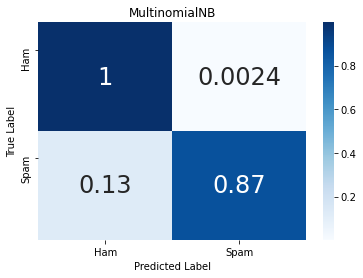

In [17]:
MNB = MultinomialNB()
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}

clf_MNB = GridSearchCV(MNB, param_grid = param_grid, scoring = 'accuracy', cv = 10, verbose = False, n_jobs = -1)
best_clf_MNB = clf_MNB.fit(features_train_transformed, y_train)
print_GridSearch_Results(best_clf_MNB, 'MultinomialNB')

/Users/mehmetcil/opt/miniconda3/envs/tensorflow/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.97487179 0.97487179 0.97487179
        nan        nan        nan 0.97692308 0.97692308 0.97692308
        nan        nan        nan 0.97717949 0.97717949 0.97717949]
  warnings.warn(



 MultinomialNB Model
-------------------------------
   Best Score (accuracy): 0.977
   Best Parameters: 
      C: 2
      penalty: l2
      tol: 0.0001

Confusion matrix
 [[0.99764081 0.00235919]
 [0.15913556 0.84086444]]


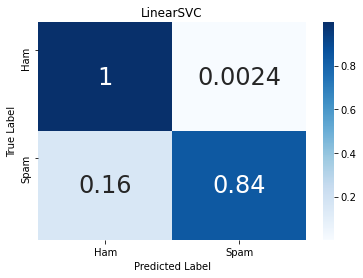

In [18]:
lsvc = LinearSVC(random_state = 0)
param_grid = {'penalty': ['l1','l2'],
               'tol': [1e-4, 5e-4, 1e-5],
               'C': [.5, 1, 2]}

clf_lsvc = GridSearchCV(lsvc, param_grid = param_grid, scoring = 'accuracy', cv = 10, verbose = False, n_jobs = -1)
best_clf_lsvc = clf_lsvc.fit(features_train_transformed, y_train)
print_GridSearch_Results(best_clf_lsvc, 'LinearSVC')


 MultinomialNB Model
-------------------------------
   Best Score (accuracy): 0.953
   Best Parameters: 
      criterion: entropy
      max_depth: 10
      min_samples_leaf: 3
      min_samples_split: 2

Confusion matrix
 [[0.99321734 0.00678266]
 [0.31827112 0.68172888]]


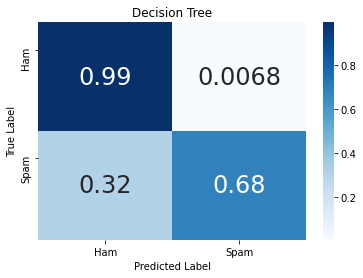

In [19]:
DT = DecisionTreeClassifier(random_state = 0)
param_grid = {'criterion': ['entropy', 'gini'],
              'max_depth': [2,6,10],
              'min_samples_leaf': [2, 3, 5],
              'min_samples_split': [2, 3, 5, 7]}

clf_DT = GridSearchCV(DT, param_grid = param_grid, scoring = 'accuracy', cv = 10, verbose = False, n_jobs = -1)
best_clf_DT = clf_DT.fit(features_train_transformed, y_train)
print_GridSearch_Results(best_clf_DT, 'Decision Tree')

/Users/mehmetcil/opt/miniconda3/envs/tensorflow/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.86948718 0.86948718 0.86948718        nan 0.86948718
 0.86948718 0.86948718        nan 0.86897436 0.86948718 0.86948718
        nan 0.94948718 0.94692308 0.94717949        nan 0.97025641
 0.97333333 0.97333333]
  warnings.warn(



 MultinomialNB Model
-------------------------------
   Best Score (accuracy): 0.973
   Best Parameters: 
      C: 10
      max_iter: 100
      penalty: l2
      solver: lbfgs

Confusion matrix
 [[0.99823061 0.00176939]
 [0.19253438 0.80746562]]


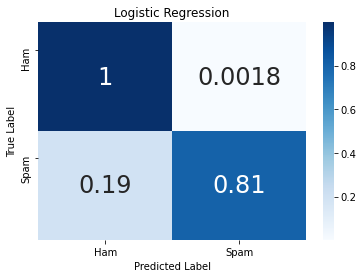

In [20]:
lr = LogisticRegression(random_state = 0)
param_grid = {'max_iter' : [100], 'penalty' : ['l1', 'l2'],'C' : [0.001, 0.01, 0.1, 1, 10],
              'solver' : ['lbfgs', 'liblinear']}
clf_lr = GridSearchCV(lr, param_grid = param_grid, scoring = 'accuracy', cv = 10, verbose = False, n_jobs = -1)
best_clf_lr = clf_lr.fit(features_train_transformed, y_train)
print_GridSearch_Results(best_clf_lr, 'Logistic Regression')

In [21]:
pd.DataFrame(comparison_dict,index = ['Accuracy', 'Precision', 'Recall'])

,MultinomialNB,LinearSVC,Decision Tree,Logistic Regression
Accuracy,0.981282,0.977179,0.952564,0.973333
Precision,0.982301,0.981651,0.937838,0.985612
Recall,0.872299,0.840864,0.681729,0.807466


### Check test dataset

In [22]:
comparison_test_dict={}
def test_func(classifier_name,classifier):
    y_pred = classifier.predict(features_test_transformed )
    cm = confusion_matrix(y_test, y_pred, normalize = 'true')
    plot_conf_mx(cm, classifier_name)
    
    comparison_test_dict[classifier_name] = [accuracy_score(y_test, y_pred), 
                                             precision_score(y_test, y_pred),
                                             recall_score(y_test, y_pred)]

In [23]:
estimators=[(best_clf_MNB.best_estimator_, 'MultinomialNB'),
            (best_clf_lsvc.best_estimator_, 'LinearSVC'),
            (best_clf_DT.best_estimator_, 'Decision Tree'),
            (best_clf_lr.best_estimator_, 'Logistic Regression')]

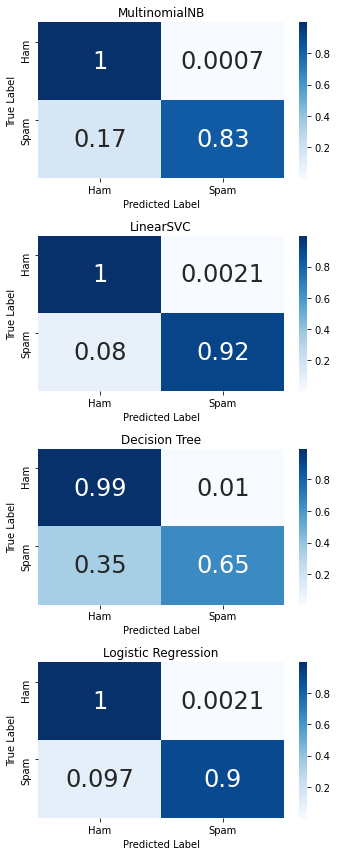

In [24]:
fig = plt.subplots(len(estimators), 1, figsize = (5, len(estimators)*3))
for i in range(len(estimators)):
    plt.subplot(len(estimators), 1, i + 1)
    test_func(estimators[i][1], estimators[i][0])
plt.tight_layout();

### Compare model predictions

In [25]:
comparison_test_df = pd.DataFrame(comparison_test_dict, index = ['Accuracy', 'Precision', 'Recall']).T
comparison_test_df.style.highlight_max(color = 'indianred', axis = 0)

,Accuracy,Precision,Recall
MultinomialNB,0.975478,0.994975,0.831933
LinearSVC,0.986842,0.986486,0.920168
Decision Tree,0.940789,0.911243,0.647059
Logistic Regression,0.984450,0.986239,0.903361


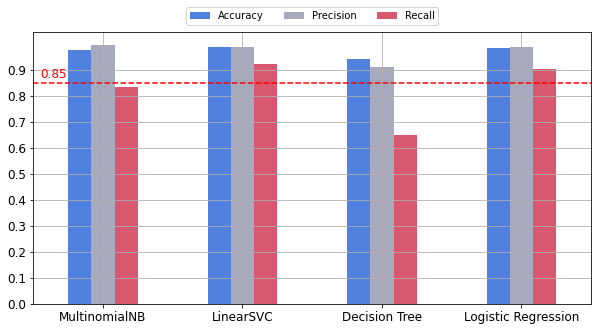

In [26]:
comparison_test_df.plot(kind = 'bar', figsize = (10, 5), fontsize = 12, grid='on',
                        color = ['#5081DE', '#A7AABD', '#D85870'])

plt.legend(loc = 'upper center', ncol = len(comparison_test_df.columns), bbox_to_anchor = (0.5, 1.11))
plt.xticks(rotation = 0)
plt.yticks(list(np.arange(0.0,1.0,0.1)))

# Plot a reference line for compariosn
plt.axhline(y = 0.85, color = 'red', linestyle = '--')
plt.text(x = -0.45, y = 0.87, s = '0.85', size = 12, color = 'red');

### References:

1. [How to Build a Spam Classifier in 10 Steps](https://towardsdatascience.com/how-to-build-your-first-spam-classifier-in-10-steps-fdbf5b1b3870), by Samima Khan